In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard

In [41]:
MAXLEN = 300
MAXWORDS = 10000
NUM_TRAIN = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
NUM_EPOCH = 5
SEED = 1992

In [42]:
np.random.seed(SEED)

### Overview

1. Have a look at the movie review dataset. E.g. what is the distribution of lenghts of the reviews, how many different tokens are there, etc..  
1a. Load the data from floydhub  
1b. Tokenize reviews  
1c. Create plots

2. Code up model  
2a. Preprocess inputs by removing rare words and padding review to same length  
2b. Code up DL model with keras api

#### IMDB dataset

In [4]:
train_path = "/floyd/input/imdb/train.tsv"
val_path = "/floyd/input/imdb/val.tsv"

In [5]:
reviews_train = pd.read_csv(train_path, delimiter="\t")
reviews_val = pd.read_csv(val_path, delimiter="\t")

In [6]:
print("Loaded {} training samples, {} test samples".format(len(reviews_train),len(reviews_val)))

Loaded 25000 training samples, 25000 test samples


Here is an exemplary negative review:

In [7]:
reviews_train.loc[reviews_train.label == 0].text.iloc[0]

"Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege!"

... and here a positive review:

In [8]:
reviews_train.loc[reviews_train.label == 1].text.iloc[0]

".......Playing Kaddiddlehopper, Col San Fernando, etc. the man was pretty wide ranging and a scream. I love watching him interact w/ Amanda Blake, or Don Knotts or whomever--he clearly was having a ball and I think he made it easier on his guests as well--so long as they Knew ahead of time it wasn't a disciplined, 19 take kind of production. Relax and be loose was clearly the name of the game there.<br /><br />He reminds me of guys like Milton Berle, Benny Hill, maybe Jerry Lewis some too. Great timing, ancient gags that kept audiences in stitches for decades, sheer enjoyment about what he was doing. His sad little clown he played was good too--but in a touching manner.<br /><br />Personally I think he's great, having just bought a two DVD set of his shows from '61 or so, it brings his stuff back in a fond way for me. I can remember seeing him on TV at the end of his run when he was winding up the series in 1971 or so.<br /><br />Check this out if you are a fan or curious. He was a ri

Let's tokenize the reviews

In [9]:
tokenizer = Tokenizer(num_words=MAXWORDS)

In [10]:
tokenizer.fit_on_texts((text for text in reviews_train.text.values))
sequences = tokenizer.texts_to_sequences([text for text in reviews_train.text.values])

In [11]:
df_token = pd.DataFrame({"TokenCount": [len(seq) for seq in sequences]})

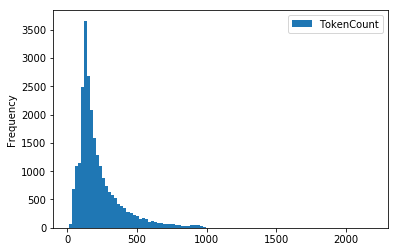

In [12]:
df_token.TokenCount.plot.hist(bins=100, legend=True);

### Data

In [33]:
data = pad_sequences(sequences, maxlen=MAXLEN)
labels = reviews_train.label.values

In [34]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [35]:
x_train = data[:NUM_TRAIN]
y_train = labels[:NUM_TRAIN]
x_val = data[NUM_TRAIN:]
y_val = labels[NUM_TRAIN:]

### Model

In [37]:
model = Sequential()
model.add(Embedding(MAXWORDS, EMBEDDING_DIM, input_length=MAXLEN)) # takes tensor (batchsize,inputdim) where 
                                                                   # inputdim == sequence length
                                                                   # returns (batchsize, inputdim, embeddingdim)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 1,960,065
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

callbacks = [
    TensorBoard(
        log_dir="logs",
        histogram_freq=1,
        embeddings_freq=1
    )
]

history = model.fit(x=x_train, y=y_train, epochs=NUM_EPOCH, batch_size=BATCH_SIZE, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 17s 868us/step - loss: 0.1051 - acc: 0.9616 - val_loss: 0.3873 - val_acc: 0.8582
Epoch 2/5
20000/20000 [==============================] - 19s 940us/step - loss: 0.0117 - acc: 0.9964 - val_loss: 0.6050 - val_acc: 0.8532
Epoch 3/5
20000/20000 [==============================] - 17s 873us/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.7726 - val_acc: 0.8458
Epoch 4/5
20000/20000 [==============================] - 17s 867us/step - loss: 1.2245e-04 - acc: 1.0000 - val_loss: 0.9913 - val_acc: 0.8402
Epoch 5/5
20000/20000 [==============================] - 17s 861us/step - loss: 5.0156e-07 - acc: 1.0000 - val_loss: 1.0963 - val_acc: 0.8356
